A typical dataset for bipartite network construction consists of objects and their properties. In this case study, objects are subjects of a mental trauma study (suitably anonymized), and properties are their trauma types.

In [2]:
import pandas as pd
import numpy as np
import networkx as nx
from networkx.algorithms.bipartite import sets, weighted_projected_graph
from networkx.drawing.nx_agraph import graphviz_layout
import scipy.spatial.distance as dist
from scipy.stats import pearsonr
import community
import matplotlib.pyplot as plt

In [3]:
matrix = pd.read_csv(r'E:\OneDrive - 同济大学\03 - 阅读\network analysis\complex network analysis in python_code\code\jri_data.csv')
patients = matrix.index
traumas = matrix.columns
print(patients)
print(traumas)
'''
The trauma names are reasonably self-explanatory, except for PSYC_MALTX (“physical maltreatment”), WAR_NOT_US (“war outside the USA”), and EXT_INTERPER_VIOLENCE (“extended interpersonal violence”).
'''

RangeIndex(start=0, stop=618, step=1)
Index(['SEXUAL_ABUSE', 'SEXUAL_ASSAULT', 'PHYSICAL_ABUSE', 'PHYSICAL_ASSAULT',
       'PSYC_MALTX', 'NEGLECT', 'DOMESTIC_VIOLENCE', 'WAR', 'WAR_NOT_US',
       'MEDICAL_TRAUMA', 'INJURY_ACCIDENT', 'NATURAL_DISASTER', 'KIDNAP',
       'TRAUMTIC_LOSS', 'FORCED_DISPLACEMENT', 'IMPAIRED_CAREGIVER',
       'EXT_INTERPER_VIOLENCE', 'COMMUNITY_VIOLENCE', 'SCHOOL_VIOLENCE'],
      dtype='object')


'\nThe trauma names are reasonably self-explanatory, except for PSYC_MALTX (“physical maltreatment”), WAR_NOT_US (“war outside the USA”), and EXT_INTERPER_VIOLENCE (“extended interpersonal violence”).\n'

In [4]:
# construct the unweighted bipartite graph
stacked = matrix.stack()
edges = stacked[stacked > 0].index.tolist()
G = nx.Graph(edges)

'''
this is used to visualize the graph
# arrage the position for bipartite graph
position =dict()
position.update((patient,(1, i)) for i,patient in enumerate(patients))
position.update((trauma, (2, i)) for i,trauma in enumerate(traumas))

# draw the graph
fig = plt.figure(figsize = (50,50))
ax = plt.subplot()
nx.draw(G, pos = position, with_labels = True, node_size = 8000, ax = ax)

'''

# make sure whether it is a bipartite graph
print(nx.is_bipartite(G))

True


## Build weighted networks based on similarity
- Below is the construction of a patients' graph based on cosine similarity

In [5]:
#  exclude all patients who have a total of 0 trauma
sum_ma = matrix.sum(axis = 1)
matrix_1 = matrix[sum_ma>0].reset_index(drop = True)

In [6]:
# construct the adjacency matrix
cos_dict = {j:[1 - dist.cosine(matrix_1.loc[i], matrix_1.loc[j]) for i in range(len(matrix_1))] for j in range(len(matrix_1))}
cos_df = pd.DataFrame(cos_dict, index = np.arange(len(matrix_1)))

# convert the similarity dataframe to graph
cos_dict = cos_df.stack().to_dict()
G_cos = nx.Graph()
G_cos.add_weighted_edges_from([(key[0],key[1],value) for key, value in cos_dict.items() if value > 0 and value < 1])

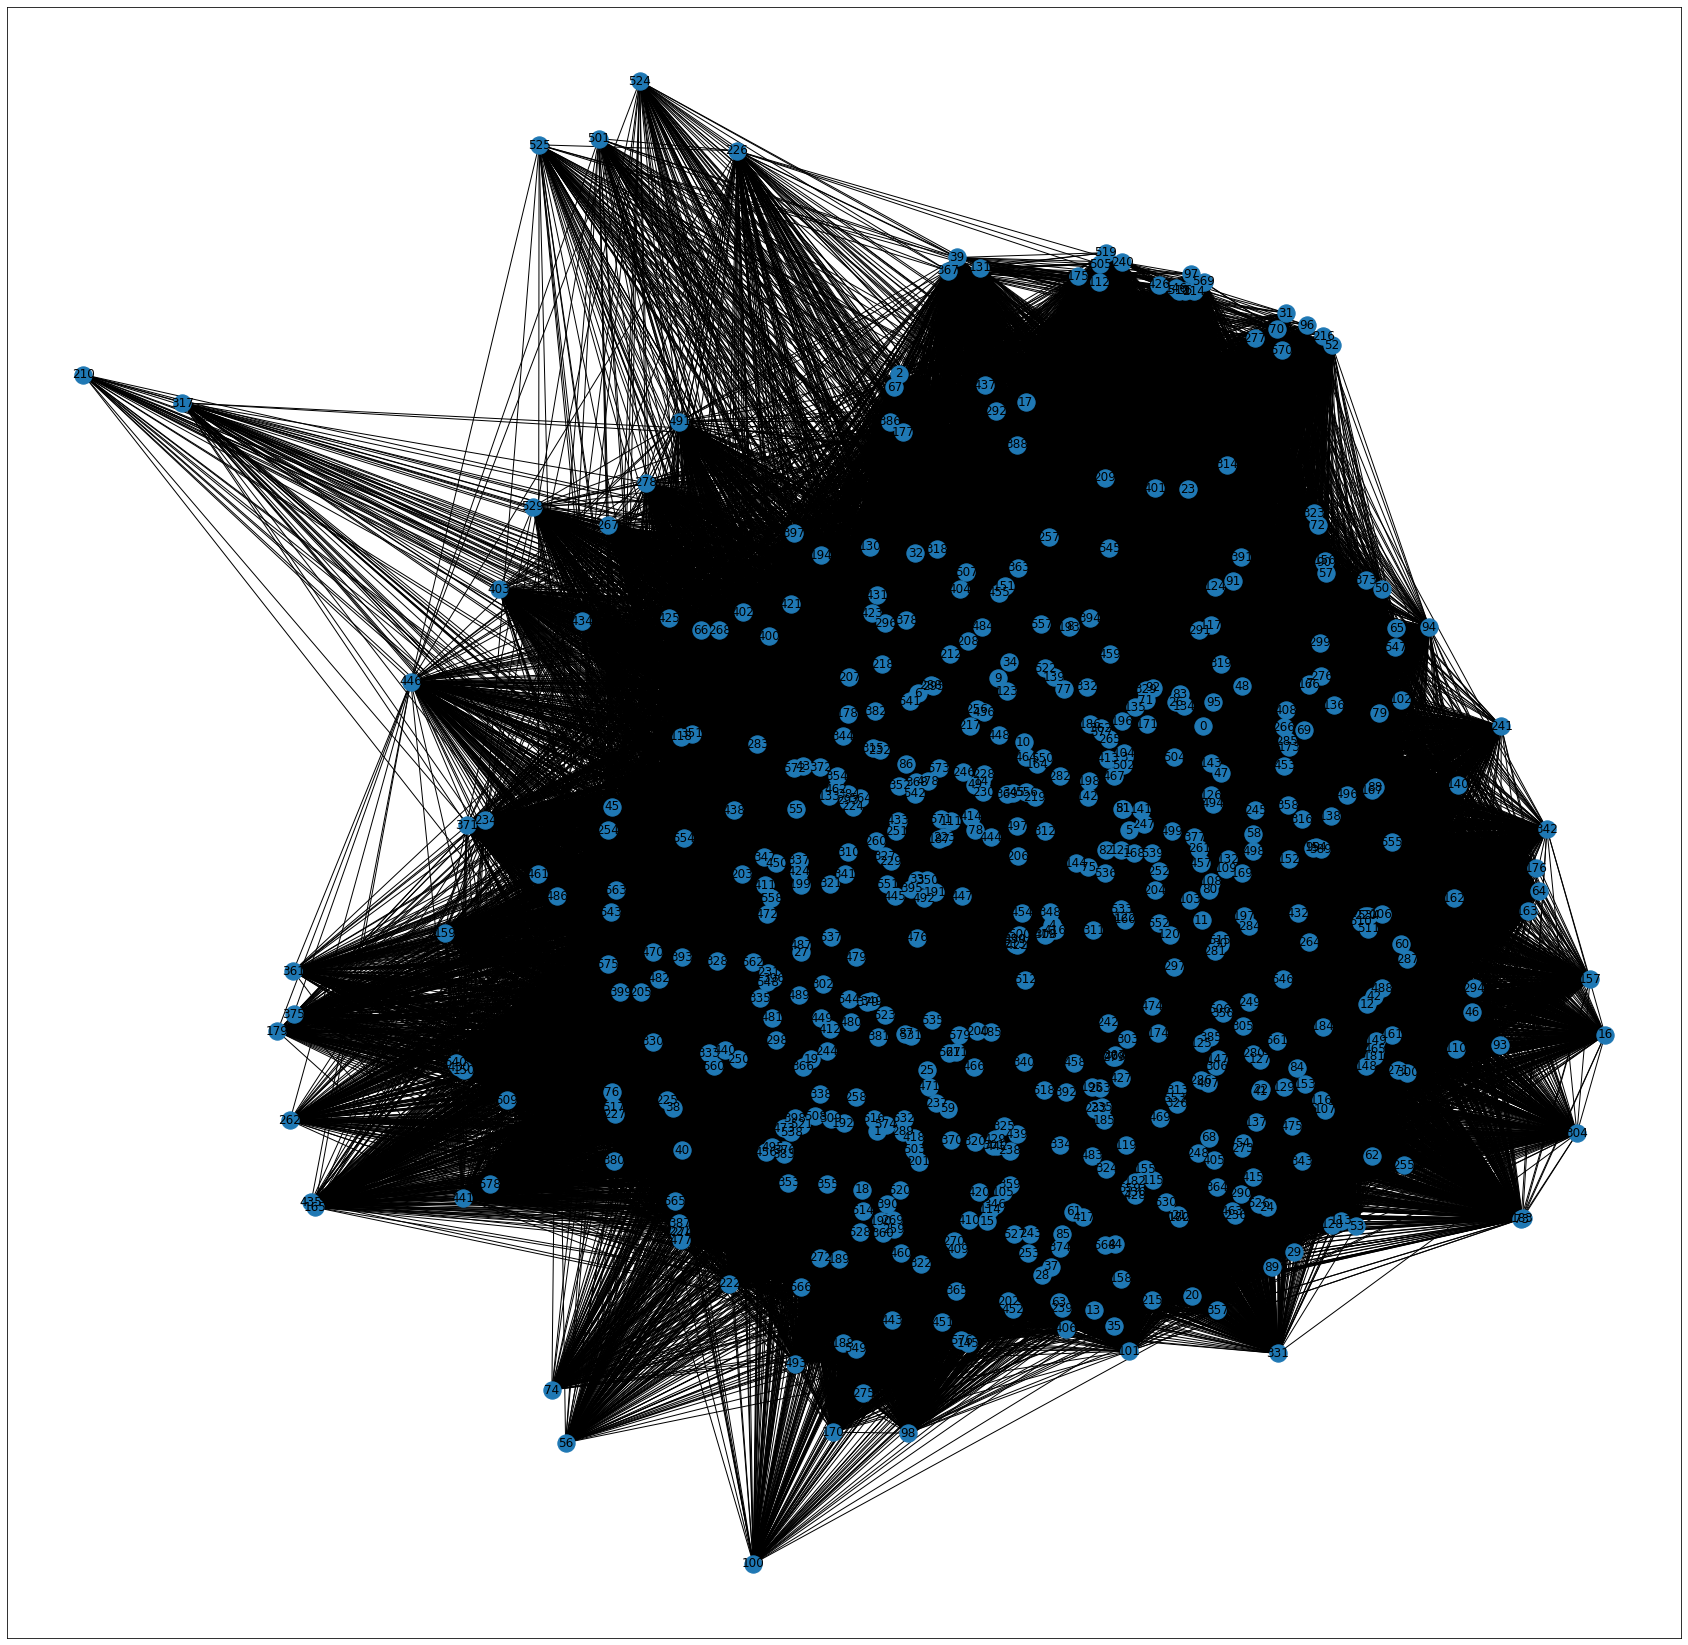

In [7]:
fig = plt.figure(figsize = (30,30))
ax = plt.subplot()
nx.draw_networkx(G_cos, ax = ax)

- Below is the construction of traumas' graph based on 3 kinds of similarity

In [8]:
# input the matrix and the function to calculate similarity and return the generated graph
def construct_graph_sim(matrix, sim_func):
    # construct the adjacency matrix
    adj_dict = {column1:[sim_func(matrix[column1], matrix[column2]) for column2 in matrix.columns] for column1 in matrix.columns}
    adj_df = pd.DataFrame(adj_dict,index = matrix.columns)
    
    #convert the adjacency matrix to graph
    edge_dict = adj_df.stack().to_dict()
    G = nx.Graph()
    G.add_weighted_edges_from([(key[0],key[1],value) for key, value in edge_dict.items() if value > 0 and value < 1])
    return G

# calculate the similarity
def cosine_sim(x,y):
    return 1 - dist.cosine(x,y)

def hamming_sim(x,y):
    return 1 - dist.hamming(x,y)

def man_sim(x,y):
    return 1/(dist.cityblock(x,y) + 1)

def pearson_sim(x,y):
    return pearsonr(x,y)[0]

# slice the graphs
def slice_graph(G, density):
    # discard insignificant edges so that the density of the graph remains certain degree
    edge_num = int((len(G) * (len(G) - 1))/2 * density)
    weak_edges = [(u,v) for u,v,w in sorted(G.edges(data = True), key = lambda x:x[2]['weight'], reverse = True)[edge_num:]]
    G.remove_edges_from(weak_edges)
    return G

In [9]:
# construct and slice the graphs
density = 0.4
G_cos = slice_graph(construct_graph_sim(matrix, cosine_sim),density)
G_pearson = slice_graph(construct_graph_sim(matrix, pearson_sim),density)
G_hamming = slice_graph(construct_graph_sim(matrix, hamming_sim),density)
G_man = slice_graph(construct_graph_sim(matrix, man_sim),density)

# G_pearson = construct_graph_sim(matrix, pearson_sim)
# G_hamming = construct_graph_sim(matrix, hamming_sim)
# G_man = construct_graph_sim(matrix, man_sim)

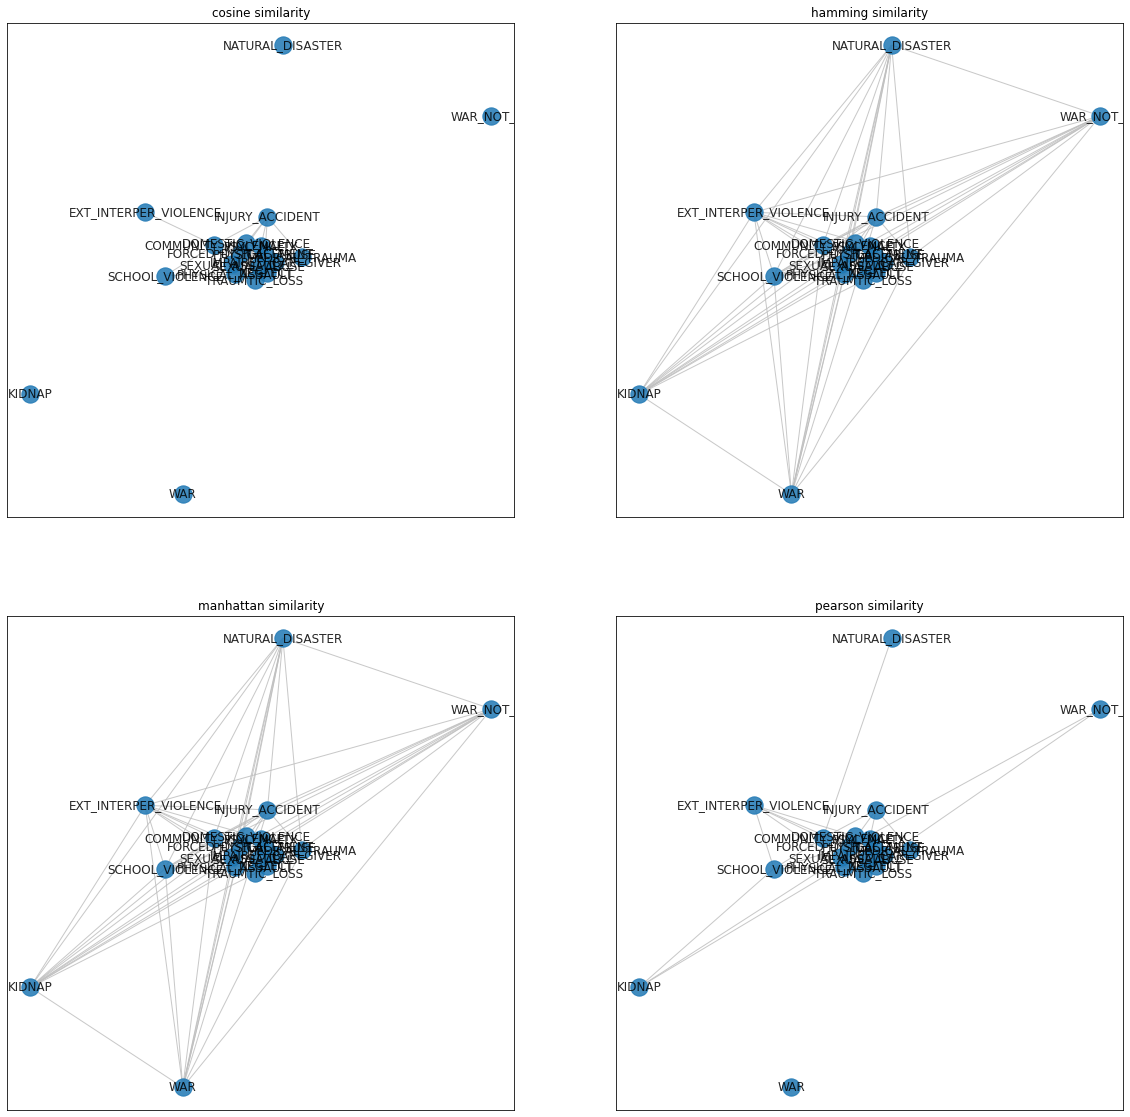

In [10]:
# draw the graphs
pos = nx.spring_layout(G_cos)

fig = plt.figure(figsize = (20,20))
ax0 = plt.subplot(221)
ax0.set_title('cosine similarity')
ax1 = plt.subplot(222)
ax1.set_title('hamming similarity')
ax2 = plt.subplot(223)
ax2.set_title('manhattan similarity')
ax3 = plt.subplot(224)
ax3.set_title('pearson similarity')

nx.draw_networkx(G_cos, pos = pos, ax = ax0, edge_color = (0.75,0.75,0.75), alpha = 0.85)
nx.draw_networkx(G_hamming, pos = pos, ax = ax1, edge_color = (0.75,0.75,0.75), alpha = 0.85)
nx.draw_networkx(G_man, pos = pos, ax = ax2, edge_color = (0.75,0.75,0.75), alpha = 0.85)
nx.draw_networkx(G_pearson, pos = pos, ax = ax3, edge_color = (0.75,0.75,0.75), alpha = 0.85)

In [11]:
part_cos = community.best_partition(G_cos)
print("cosine, modularity:{}, communities:{}".format(community.modularity(part_cos, G_cos), len(set(part_cos.values()))))

part_ham = community.best_partition(G_hamming)
print("hamming, modularity:{}, communities:{}".format(community.modularity(part_ham, G_hamming), len(set(part_ham.values()))))

part_pear = community.best_partition(G_pearson)
print("pearson, modularity:{}, communities:{}".format(community.modularity(part_pear, G_cos), len(set(part_pear.values()))))

part_man = community.best_partition(G_man)
print("manhattan, modularity:{}, communities:{}".format(community.modularity(part_man, G_man), len(set(part_man.values()))))

cosine, modularity:0.044813171071425094, communities:7
hamming, modularity:0.12028549328936763, communities:4
pearson, modularity:0.0060476756570362515, communities:8
manhattan, modularity:0.12473473323561435, communities:5


In [12]:
ser_part_man = pd.Series(part_man)
[print("community:{}, members:{}".format(i,a[a == i].index)) for i in set(part_man.values())]

NameError: name 'a' is not defined